# Import Modules

In [ ]:
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
from keras.utils import to_categorical

import os


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D,Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
import os
import cv2

# Construct Filepath image to dataframe with image classes

In [ ]:
import os
import pandas as pd


bengin_path = "/content/drive/MyDrive/BME2121_final/LungcancerDataSet/Data/train/Bengin cases"
malignant_path = "/content/drive/MyDrive/BME2121_final/LungcancerDataSet/Data/train/Malignant cases"
normal_path = "/content/drive/MyDrive/BME2121_final/LungcancerDataSet/Data/train/normal"
squamous_path = "/content/drive/MyDrive/BME2121_final/LungcancerDataSet/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa"
large_cell_path = "/content/drive/MyDrive/BME2121_final/LungcancerDataSet/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa"
adeno_path = "/content/drive/MyDrive/BME2121_final/LungcancerDataSet/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib"

path_label_mapping = {
    bengin_path: "Non cancer",
    normal_path: "Non cancer",
    malignant_path: "Cancer",
    squamous_path: "Cancer",
    large_cell_path: "Cancer",
    adeno_path: "Cancer"
}

img_path = []
class_labels = []


for dir_path, label in path_label_mapping.items():
    name_img = os.listdir(dir_path) # List all files in the directory
    for name_file in name_img: # Loop through each file
        img = os.path.join(dir_path, name_file) # Join directory path and file name to get full image path
        img_path.append(img) # Add image path to list
        class_labels.append(label) # Add label to list

# Create a DataFrame with image paths and their labels
df = pd.DataFrame({
    "img_path": img_path,
    "label": class_labels
})
df.head()

,img_path,label
0,/content/drive/MyDrive/BME2121_final/Lungcance...,Non cancer
1,/content/drive/MyDrive/BME2121_final/Lungcance...,Non cancer
2,/content/drive/MyDrive/BME2121_final/Lungcance...,Non cancer
3,/content/drive/MyDrive/BME2121_final/Lungcance...,Non cancer
4,/content/drive/MyDrive/BME2121_final/Lungcance...,Non cancer


In [ ]:
df.shape

(1460, 2)

# Visualization Image

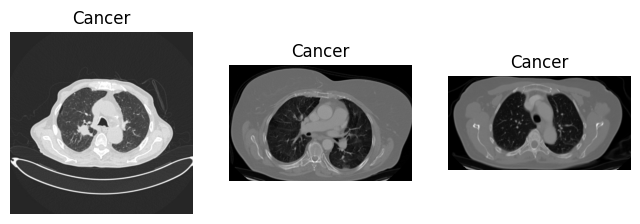

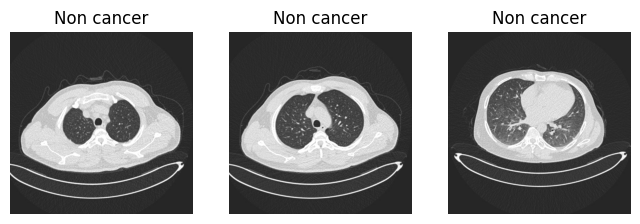

In [ ]:
for category, group in df.groupby("label"):
    fig, ax = plt.subplots(1,3, figsize = (8,8))
    ax = ax.ravel()
    for i, (_,r) in enumerate(group.sample(3).iterrows()):
        img = cv2.imread(r.img_path)
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title(r.label)
    plt.show()

In [ ]:
sizes = []
resolutions = []
color_distributions = []

for img_path in df["img_path"]:
    #load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Get image size
    size = os.path.getsize(img_path)
    sizes.append(size)
    #Extract the resolution of images
    resolution = img.shape[:2]
    resolutions.append(resolution)
    #Extract color distribution
    mean_color_distributions = np.bincount(img.flatten(), minlength = 256)
    color_distributions.append(mean_color_distributions)
sizes = np.array(sizes)
resolutions = np.array(resolutions)
color_distributions = np.array(color_distributions)

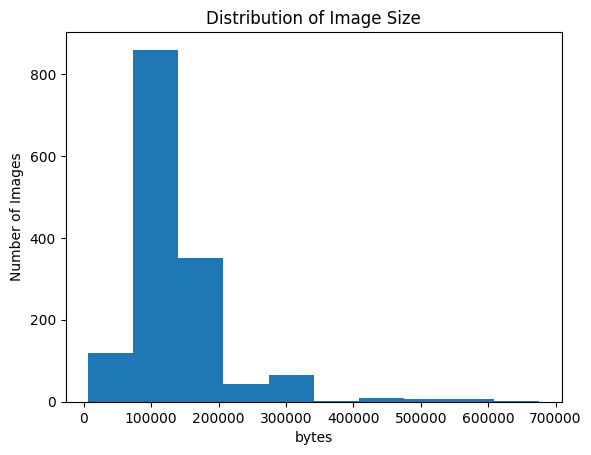

In [ ]:
plt.hist(sizes)
plt.title("Distribution of Image Size")
plt.xlabel("bytes")
plt.ylabel("Number of Images")
plt.show()

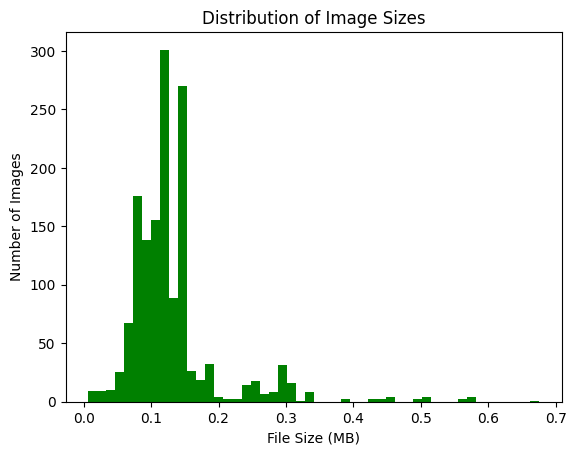

In [ ]:

sizes_MB = []
for img_path in df["img_path"]:
    img = cv2.imread(img_path)
    size = os.path.getsize(img_path)
    sizes_MB.append(size / 1_000_000)

plt.hist(sizes_MB, bins=50, color="green")
plt.xlabel("File Size (MB)")
plt.ylabel("Number of Images")
plt.title("Distribution of Image Sizes")
plt.show()

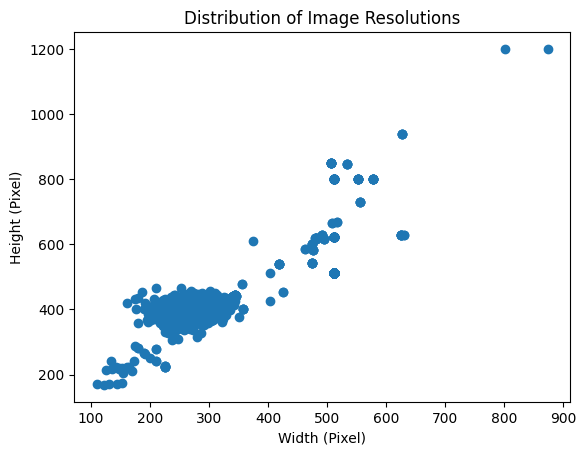

In [ ]:
plt.scatter(resolutions[:,0], resolutions[:,1])
plt.title("Distribution of Image Resolutions")
plt.ylabel("Height (Pixel)")
plt.xlabel("Width (Pixel)")
plt.show()

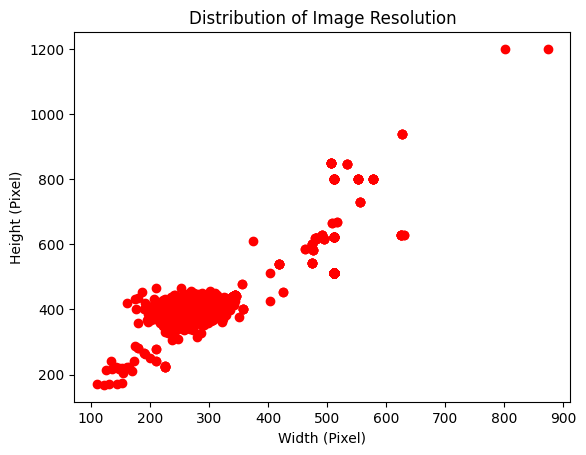

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(resolutions[:, 0], resolutions[:, 1], color="red")
plt.xlabel("Width (Pixel)")
plt.ylabel("Height (Pixel)")
plt.title("Distribution of Image Resolution")
plt.show()

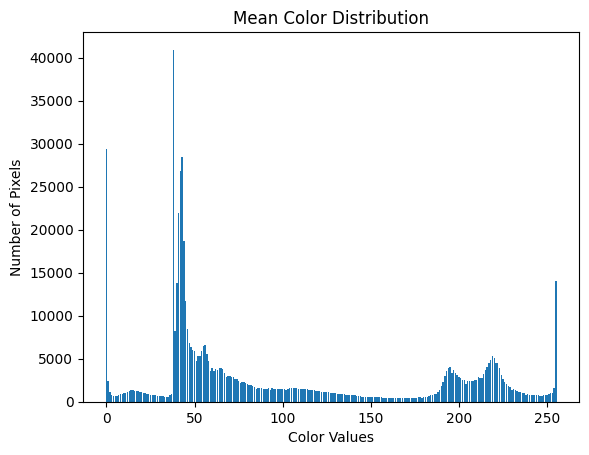

In [ ]:
import matplotlib.pyplot as plt

mean_color_distributions = np.mean(color_distributions, axis=0)

plt.bar(np.arange(256), mean_color_distributions)
plt.xlabel("Color Values")
plt.ylabel("Number of Pixels")
plt.title("Mean Color Distribution")
plt.show()

In [ ]:
train_ratio = 0.70
test_ratio = 0.15
val_ratio = 0.15

df_train, df_test_val = train_test_split(df, train_size = train_ratio, random_state = 42)
df_test, df_val = train_test_split(df_test_val, train_size = test_ratio/(test_ratio+val_ratio), random_state = 42)

print(f"Train shape = {df_train.shape}")
print(f"Test shape = {df_test.shape}")
print(f"Validation shape = {df_val.shape}")

Train shape = (1021, 2)
Test shape = (219, 2)
Validation shape = (220, 2)


In [ ]:
def preprocessing_denoise(img):
    denoise_img = cv2.medianBlur(img, 3)
    denoise_img = cv2.cvtColor(denoise_img, cv2.COLOR_BGR2RGB)
    return denoise_img

# Train Test Split & Image Data Generator

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

image_size = (IMG_WIDTH, IMG_HEIGHT)
batch_size = 32

TRAIN_DATAGEN = ImageDataGenerator(rescale = 1./255.,
                                   preprocessing_function = preprocessing_denoise,
                                  rotation_range = 30,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.2,
                                  shear_range = 0.1,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

TEST_DATAGEN = ImageDataGenerator(rescale = 1./255.)

train_generator1 = TRAIN_DATAGEN.flow_from_dataframe(
    df_train,
    x_col = "img_path",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "binary",
    shuffle = True
)

val_generator1 = TEST_DATAGEN.flow_from_dataframe(
    df_val,
    x_col = "img_path",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "binary",
    shuffle = True
)

test_generator1 = TEST_DATAGEN.flow_from_dataframe(
    df_test,
    x_col = "img_path",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "binary",
    shuffle = True
)

Found 1021 validated image filenames belonging to 2 classes.
Found 220 validated image filenames belonging to 2 classes.
Found 219 validated image filenames belonging to 2 classes.


In [ ]:
classes = list(train_generator1.class_indices.keys())
classes

['Cancer', 'Non cancer']

In [ ]:
#Weight Class
class_weights = class_weight.compute_class_weight(
           class_weight = 'balanced',
            classes = np.unique(train_generator1.classes),
            y = train_generator1.classes)

train_class_weights = dict(enumerate(class_weights))

for idx, weight, in train_class_weights.items():
    class_name = classes[idx]
    print(f"{class_name} : {weight}")

Cancer : 0.7878086419753086
Non cancer : 1.3686327077747988


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load ResNet-50 as the base model
base_model_resnet50 = ResNet50(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
                               include_top=False, weights="imagenet")

# Set all layers in the base model to be non-trainable
for layer in base_model_resnet50.layers:
    layer.trainable = False

# Build the new model
model3 = Sequential()
model3.add(Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
model3.add(base_model_resnet50)  # Add the ResNet-50 model
model3.add(Flatten())
model3.add(Dense(1024, activation="relu"))
model3.add(Dropout(0.4))
model3.add(Dense(1, activation="sigmoid"))  # Use 1 neuron and sigmoid activation for binary classification

# Print the model summary
print(model3.summary())

# Compile the model for binary classification
model3.compile(optimizer=Adam(0.0005),
               loss="binary_crossentropy",  # Use binary_crossentropy for binary classification
               metrics=["accuracy"])

# Set the training parameters
epochs = 50

# Train the model
history = model3.fit(train_generator1,
                     steps_per_epoch=len(train_generator1),  # Make sure to use train_generator here
                     validation_data=val_generator1,
                     validation_steps=len(val_generator1),  # Make sure to use val_generator here
                     class_weight=train_class_weights,  # Adjust class weights if necessary
                     callbacks=[
                         EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
                         ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min')
                     ],
                     epochs=epochs)

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 126350209 (481.99 MB)
Trainable params: 102762497 (392.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_____

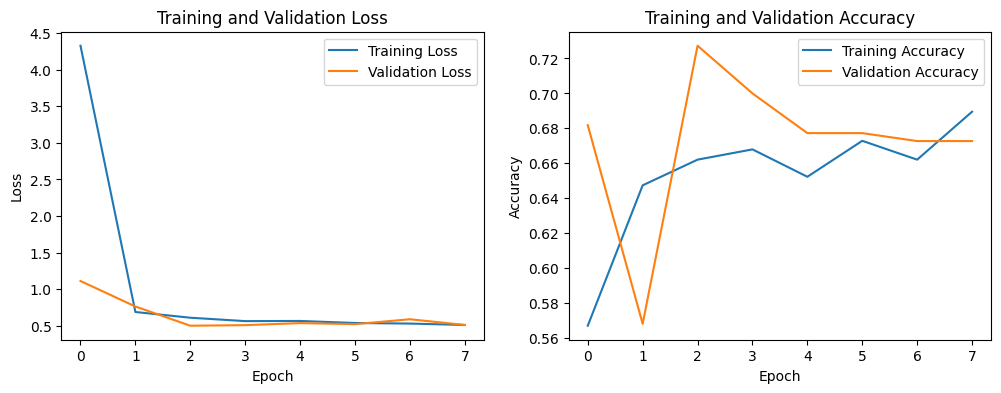

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()